# Get insides of MBT-Lenzerheide and a heatmap

## Imports

In [1]:
# general imports
import requests
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
from matplotlib import cm, colors
import ast
import datetime
import numpy as np
from ipywidgets import interact
import json
import folium
from branca.element import Template, MacroElement
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape, Point, LineString
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (16,9/3)
plt.rcParams['figure.dpi'] = 300
pd.options.display.max_columns = None

## Config

In [3]:
path2userTrails = 'RowData/Insidelab Trails/bk_user_trails.json'
path2trailDefinitons = 'RowData/Insidelab Trails/bk_trail_definitions.json'

## Load data

load trails

In [4]:
trailDefinitons = pd.read_json(path2trailDefinitons)
trailDefinitons.gps = trailDefinitons.gps.apply(lambda gps_string: ast.literal_eval(gps_string))
trailDefinitons.gps = trailDefinitons.gps.apply(lambda gps: LineString([Point(p[0], p[1]) for p in gps]))
trailDefinitons = gpd.GeoDataFrame(trailDefinitons, geometry=trailDefinitons.gps)
trailDefinitons = trailDefinitons.drop('gps', axis=1)
trailDefinitons['geojson'] = trailDefinitons.geometry.apply(lambda geometry: geometry.__geo_interface__)

In [5]:
trailDefinitons.shape

(93, 6)

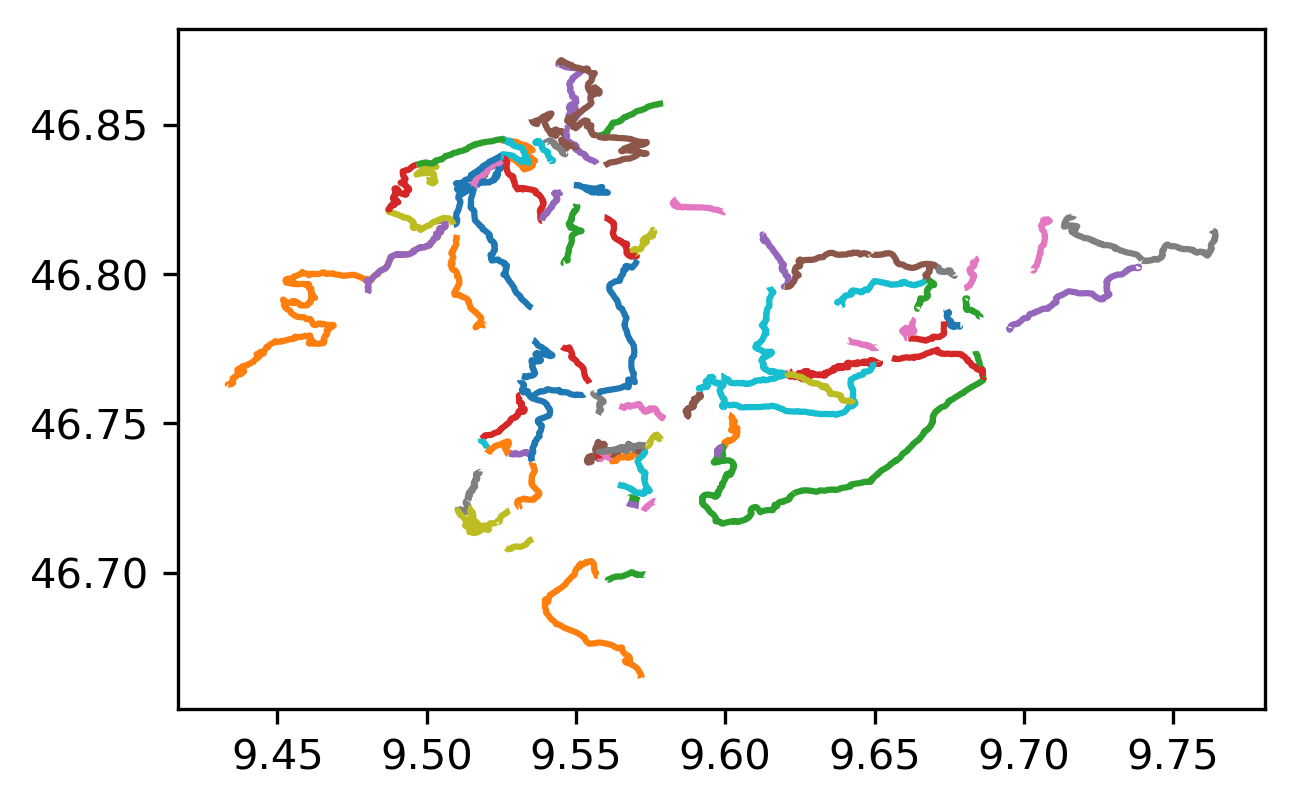

In [6]:
trailDefinitons.plot(column='title');

load users tracks

In [7]:
userTrails = pd.read_json(path2userTrails)

In [8]:
for column in userTrails:
    if column in ['started_at', 'completed_at','created_at']:
        continue
    print( '----' + column + '----')
    print(userTrails[column].value_counts()[:10].sort_values(ascending=False).to_string())
    print()

----id----
53e4301a-b355-42ca-bd02-70508057f7a9    1
7d415b37-80e9-4127-b076-48d70f74e149    1
953b5c73-8b19-44c8-9178-bc80c97ef72d    1
3aa05423-715b-4cf3-a844-38bb27d6056f    1
10db0967-f406-40af-89d9-4657e1ab1984    1
34528f3d-2e75-46d1-a804-352fed759e9f    1
cda6a3f8-3258-490e-a96c-c7fa9d2f6194    1
00b8ad9e-b0ac-438e-bf71-3f4836d21834    1
4d3c5f29-a82e-4b3c-a5dc-f941a6cd75cb    1
decf6a35-c35b-4cee-94d4-6b479c981b54    1

----user_id----
09ddbecf-4ba8-4550-8e6a-2e8ca78f68fe    1000
37fca9bc-7d3b-409f-b9e0-c68ab23d3569     832
552f8b32-4a63-40fc-a7d0-263358456210     567
81083040-07af-45c3-aff4-ff2dee6ebfa2     535
9f0bd29f-fa74-4326-828e-2808add77166     508
5026b443-efc0-401b-a90a-0fbd3982407d     427
572d5bf3-6053-4ca9-b39b-1143235c6e91     402
970cf95c-e991-42f9-934e-8913bbf9f643     359
a66d4e51-9e6b-4a0e-bfe0-69db5b0ede81     347
da46b97a-2d01-4bcd-b594-7bcb0557f1c4     320

----activity_id----
flowline-lower           4791
primeline-lower          4538
primeline            

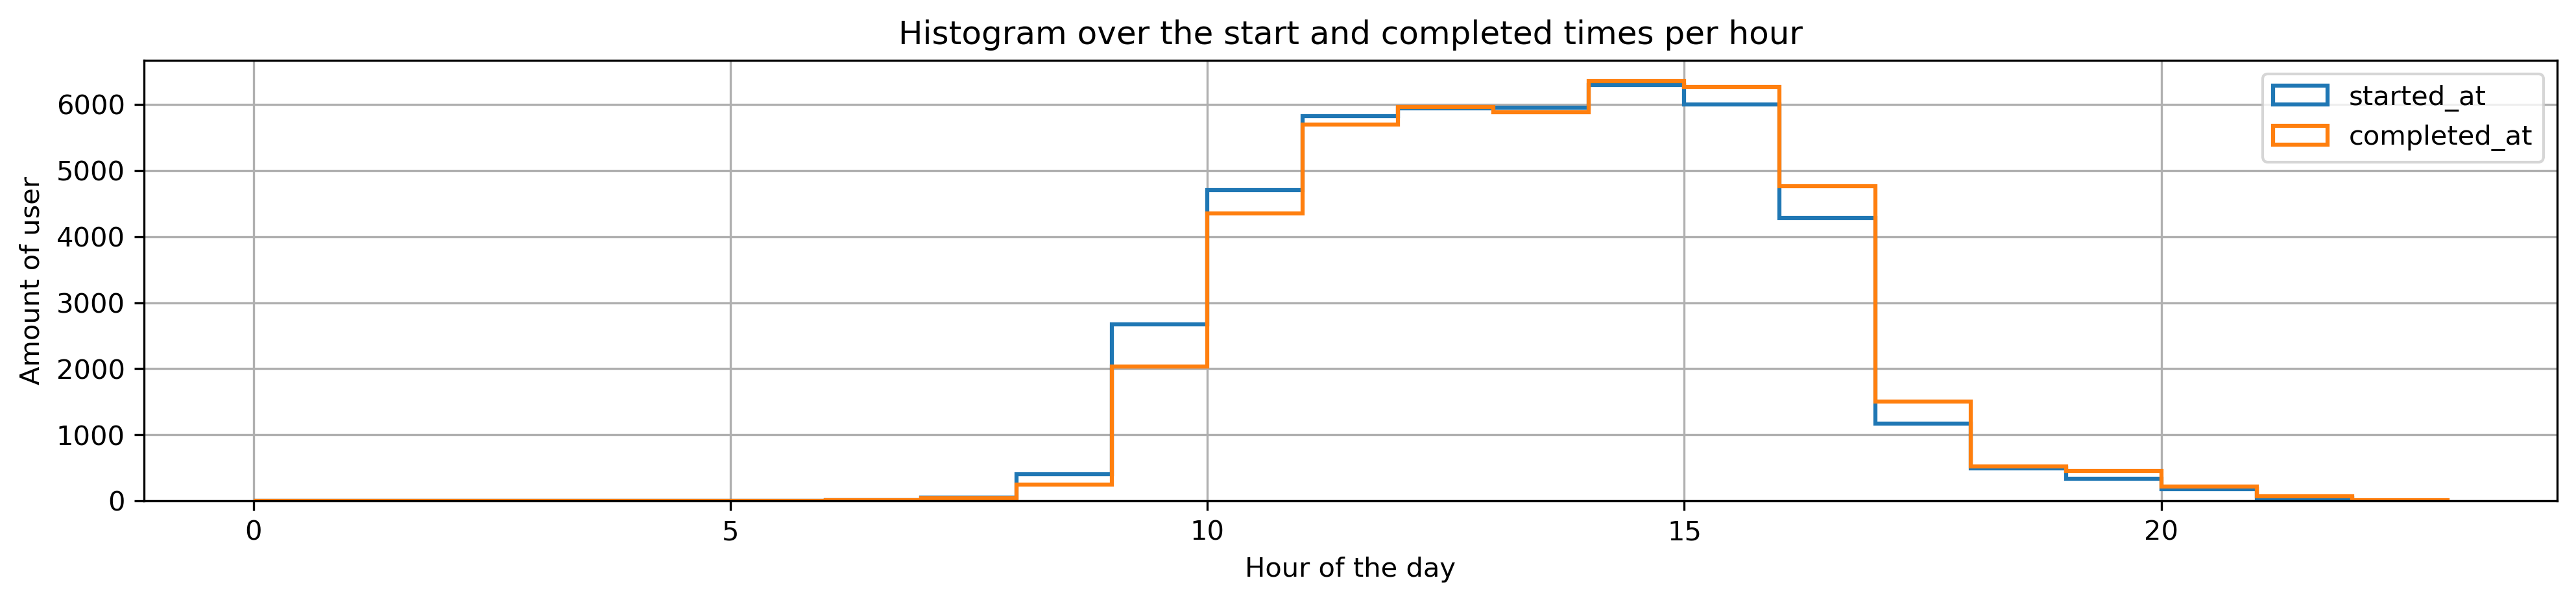

In [9]:
kwargs = dict(histtype='step', bins=range(0,24), fc='none', lw=1.5, legend=True)
userTrails.started_at.dt.hour.hist(**kwargs)
userTrails.completed_at.dt.hour.hist(**kwargs)
plt.title('Histogram over the start and completed times per hour')
plt.xlabel('Hour of the day'), plt.ylabel('Amount of user');

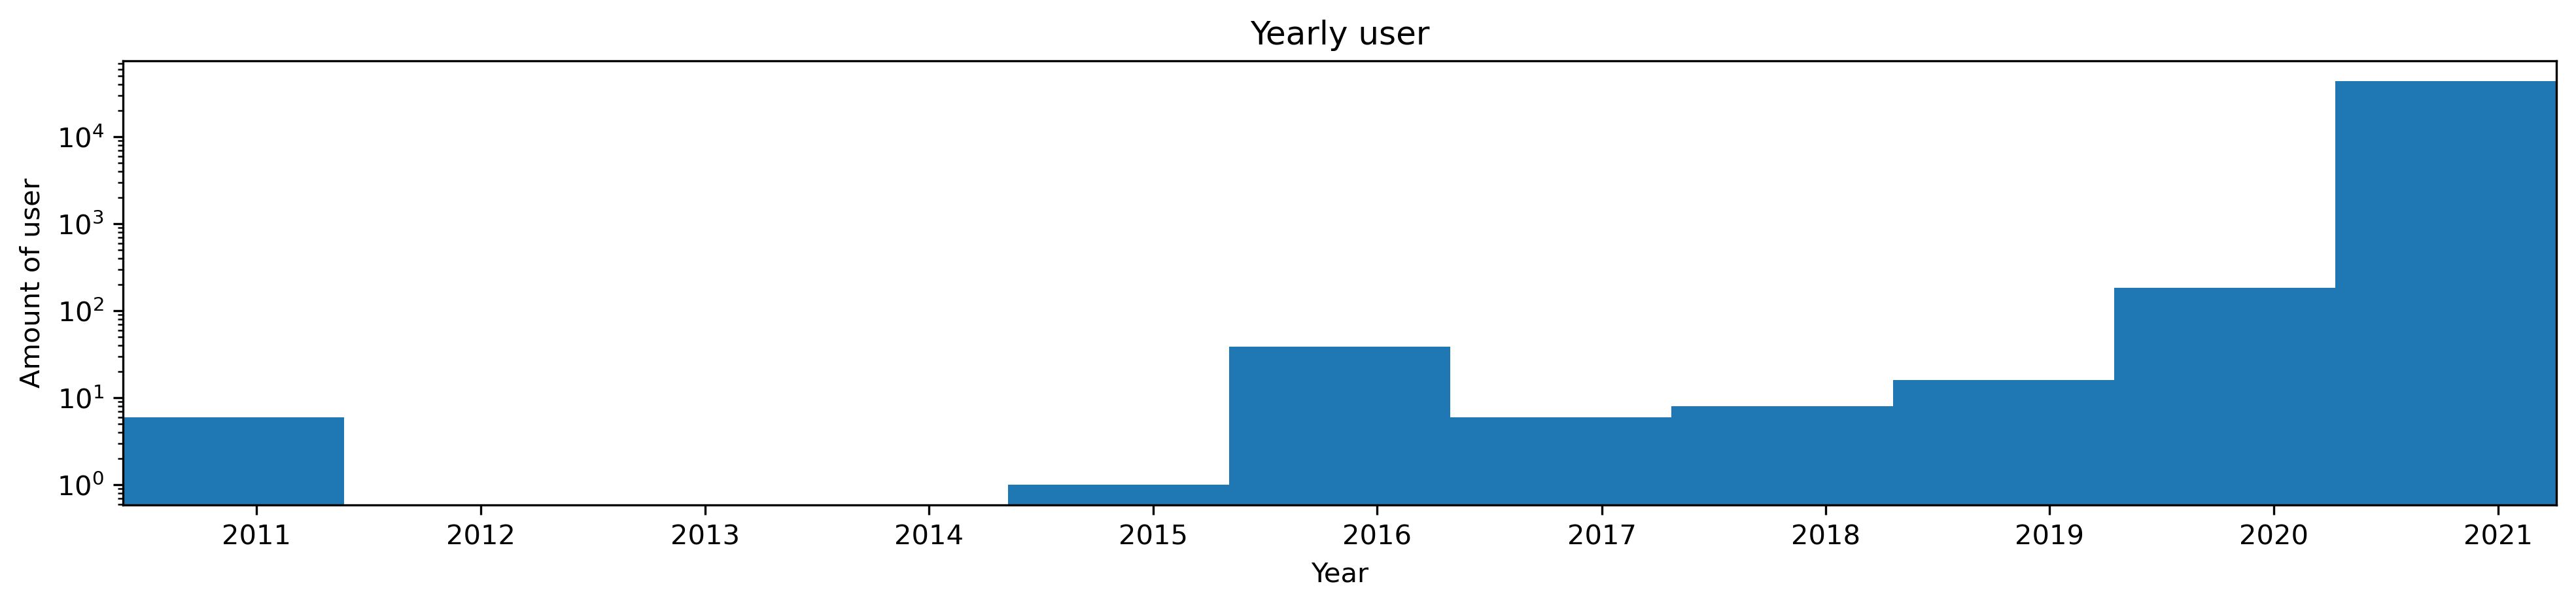

In [10]:
starting_dates = userTrails.started_at
plt.hist(starting_dates, bins=(max(starting_dates).year - min(starting_dates).year))
plt.xlim(min(starting_dates), max(starting_dates))
plt.semilogy()
plt.title('Yearly user')
plt.xlabel('Year'), plt.ylabel('Amount of user');

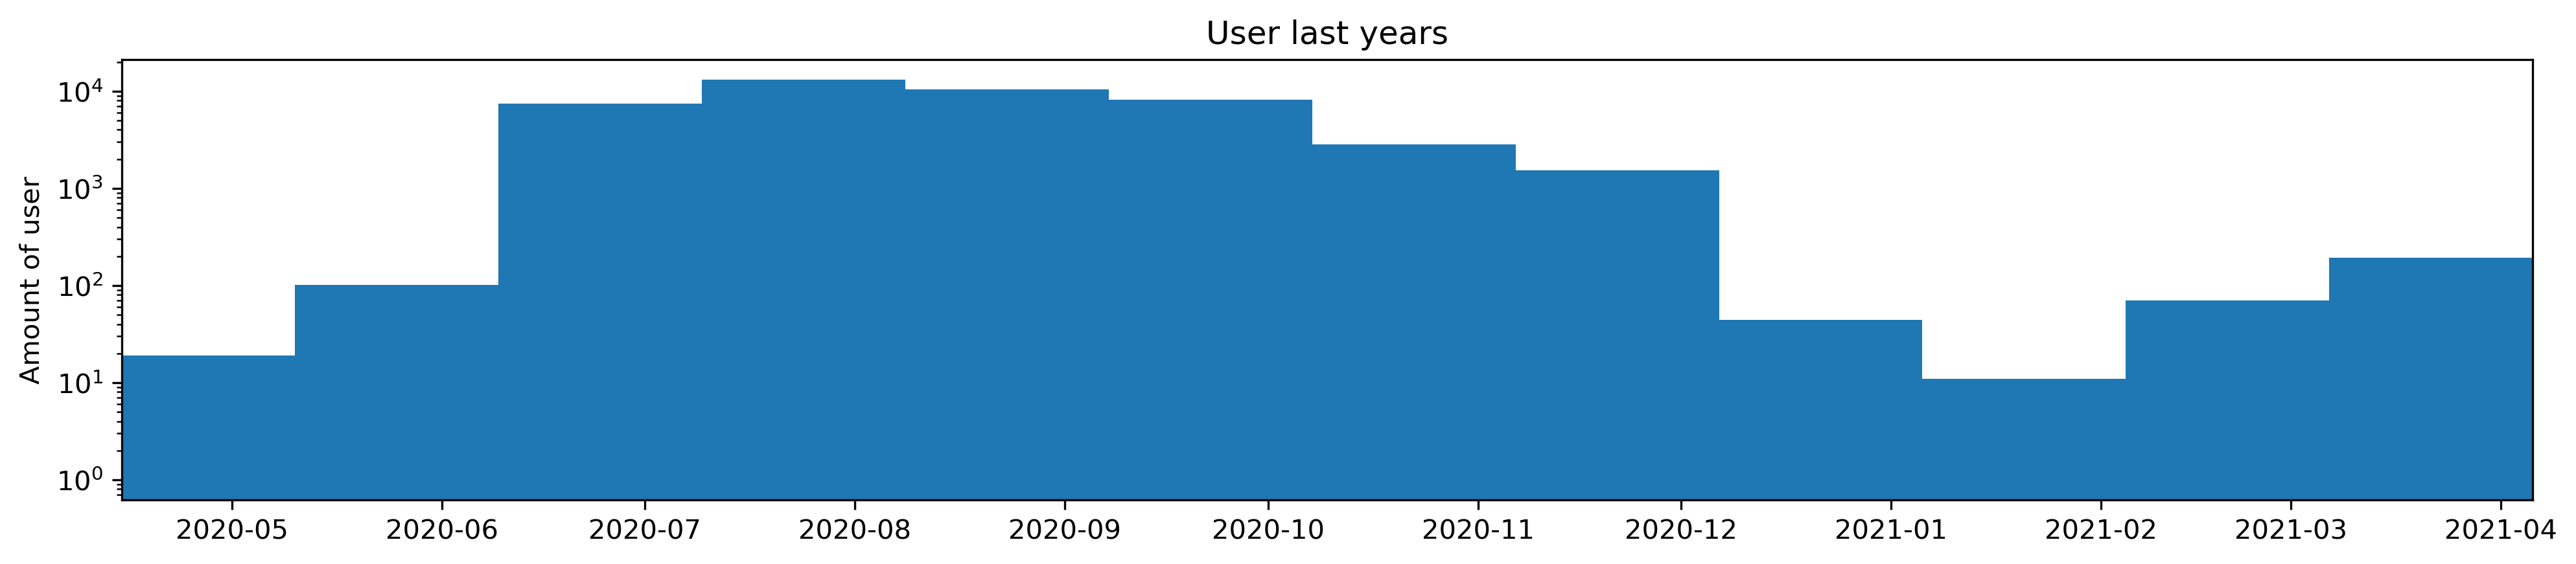

In [11]:
starting_dates = userTrails.started_at
plt.hist(starting_dates, bins=(max(starting_dates).year - min(starting_dates).year)*12)
plt.xlim((max(starting_dates)-datetime.timedelta(days = 356)), max(starting_dates))
plt.semilogy()
plt.title('User last years')
plt.ylabel('Amount of user');

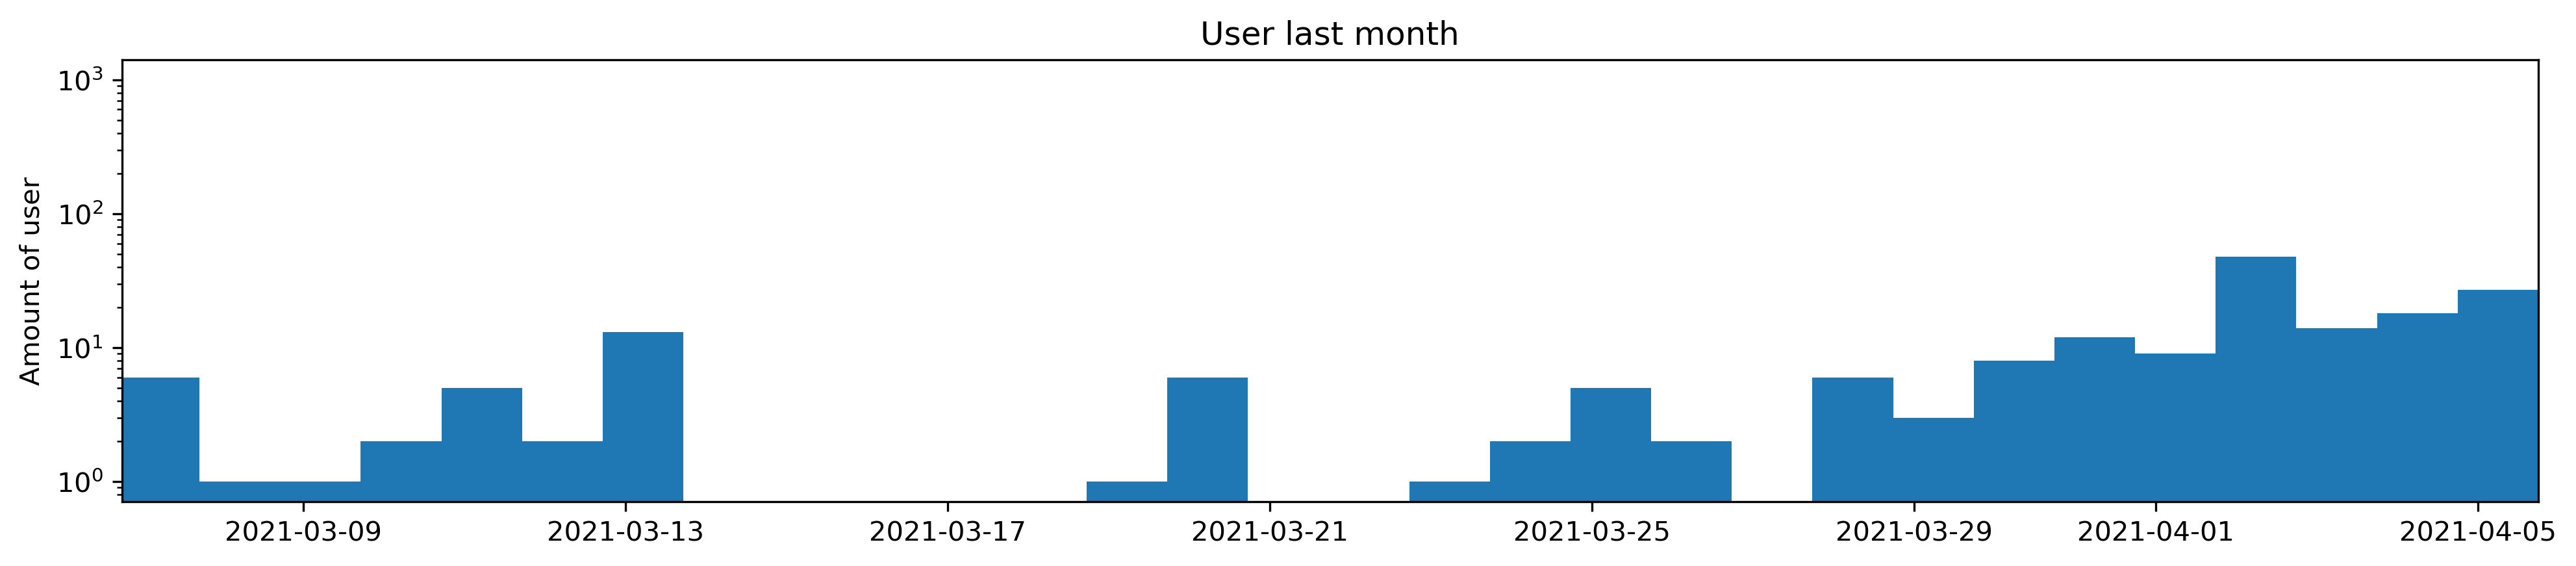

In [12]:
starting_dates = userTrails.started_at
plt.hist(starting_dates, bins=(max(starting_dates).year - min(starting_dates).year)*12*30)
plt.xlim((max(starting_dates)-datetime.timedelta(days = 30)), max(starting_dates))
plt.semilogy()
plt.title('User last month')
plt.ylabel('Amount of user');

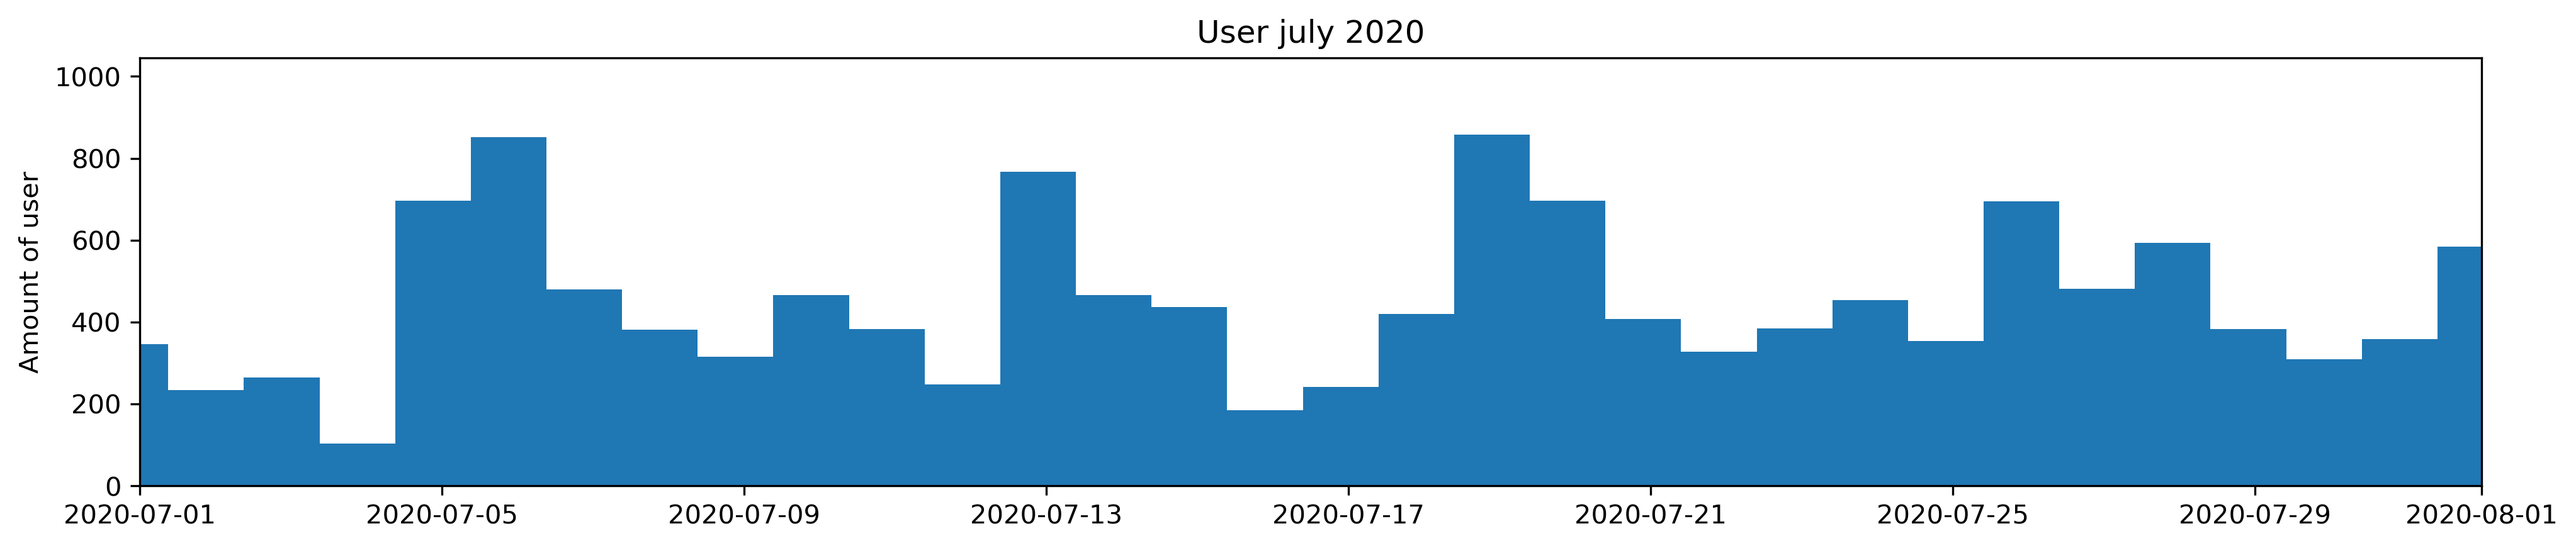

In [13]:
starting_dates = userTrails.started_at
plt.hist(starting_dates, bins=(max(starting_dates).year - min(starting_dates).year)*12*30)
plt.xlim(datetime.datetime(year= 2020, month=7, day = 1), datetime.datetime(year= 2020, month=8, day = 1))
#plt.semilogy()
plt.title('User july 2020')
plt.ylabel('Amount of user');

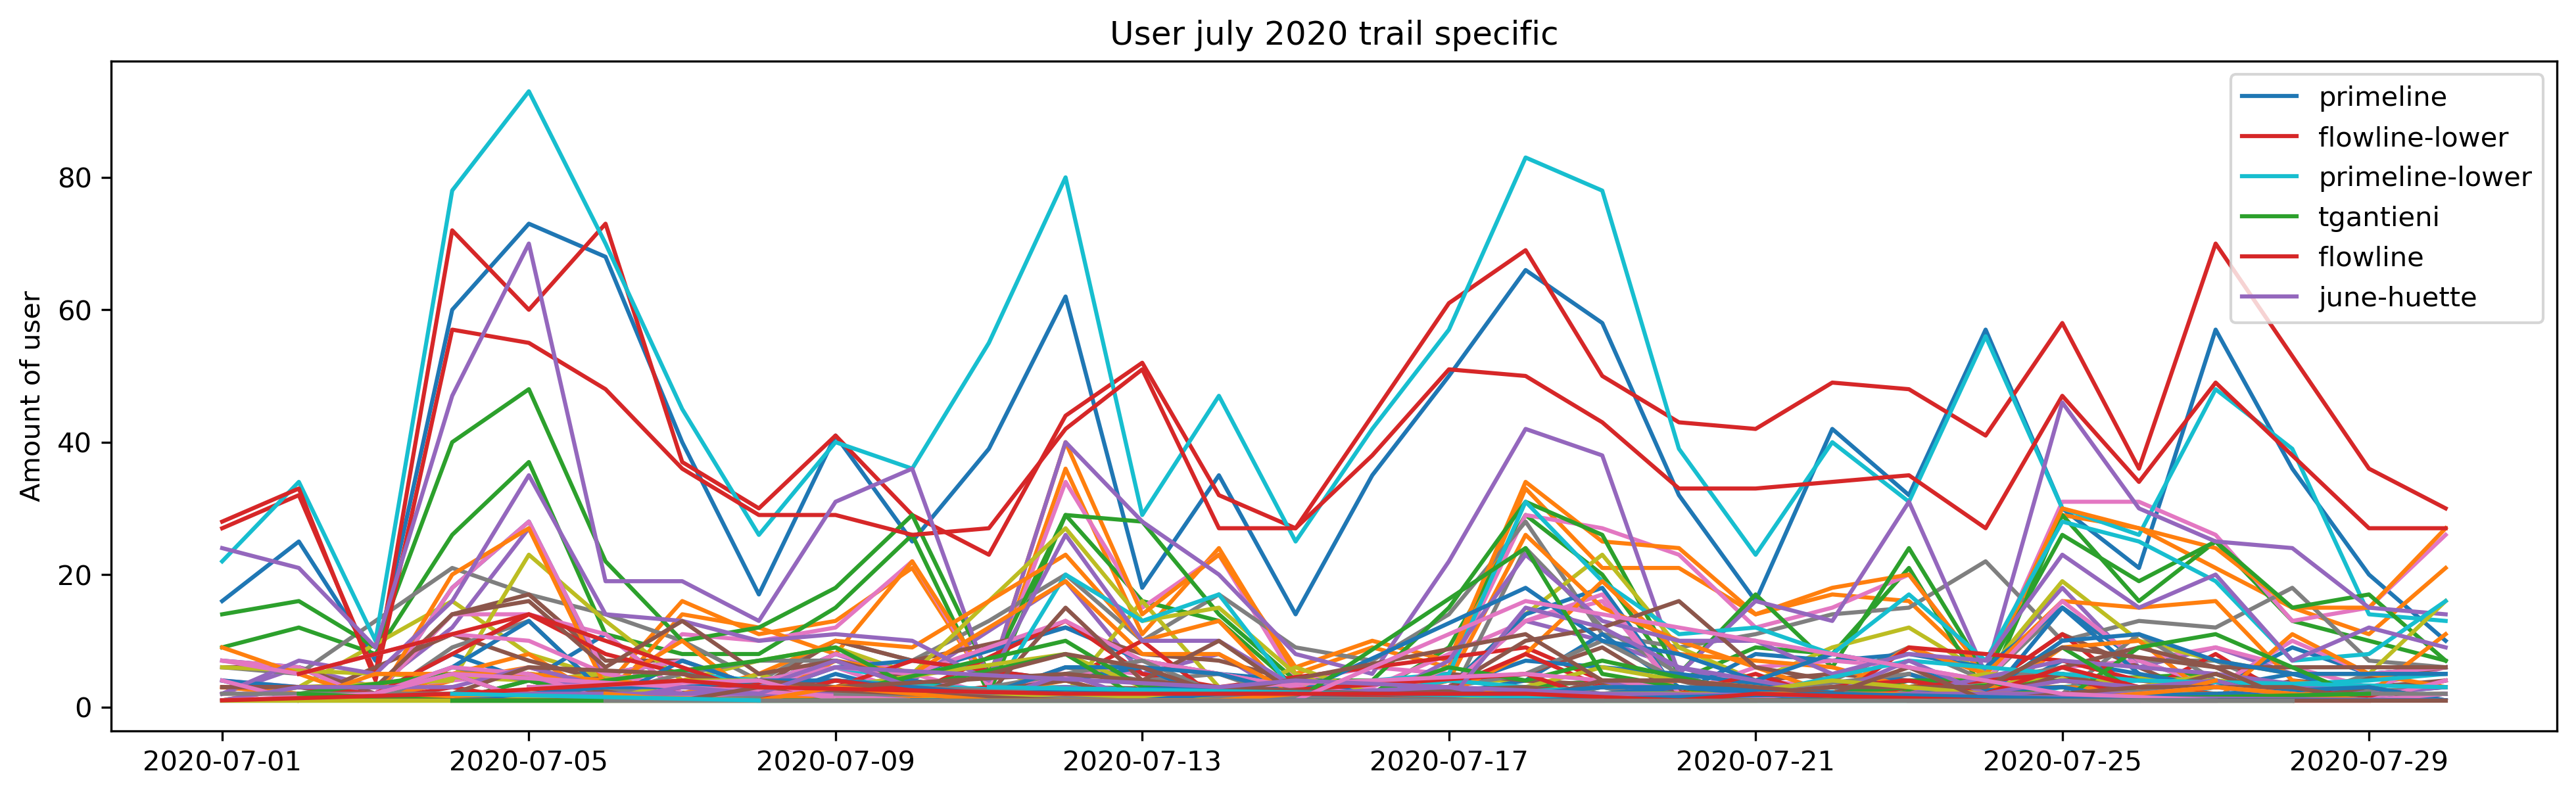

In [14]:
mask = (userTrails['started_at'] > '2020-7-1') & (userTrails['started_at'] <= '2020-7-31')
userTrails_july2020 = userTrails.loc[mask]
for trail in userTrails_july2020.activity_id.unique():
    df = userTrails_july2020[userTrails_july2020.activity_id==trail].groupby(by=userTrails_july2020.started_at.dt.date).count()
    if df.id.max()>40:
        df.user_id.plot(figsize=(16,9/2), label=trail)
    else:
        df.user_id.plot(figsize=(16,9/2), label='')
plt.legend()
plt.title('User july 2020 trail specific')
plt.xlabel(''), plt.ylabel('Amount of user');

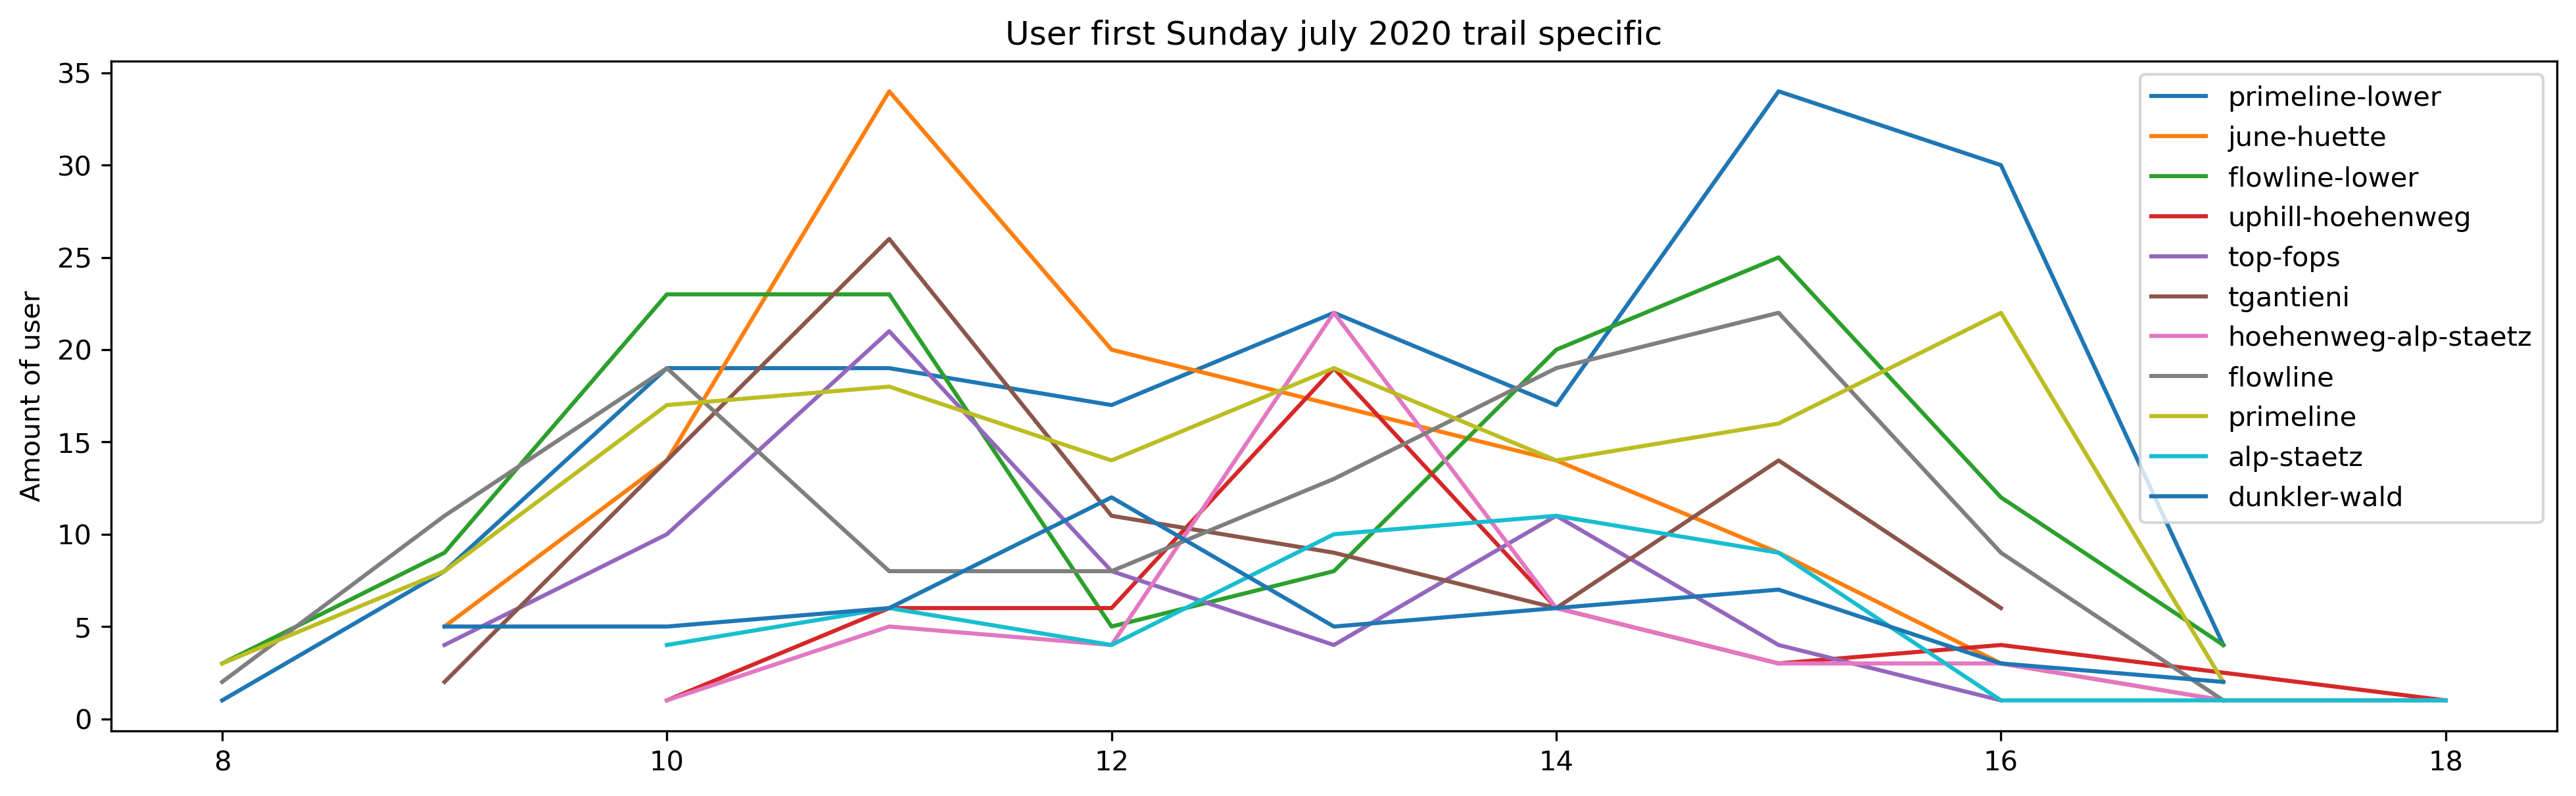

In [15]:
mask = (userTrails['started_at'] > '2020-7-4') & (userTrails['started_at'] < '2020-7-6')
userTrails_july2020 = userTrails.loc[mask]
for trail in userTrails_july2020.activity_id.unique():
    df = userTrails_july2020[userTrails_july2020.activity_id==trail].groupby(by=userTrails_july2020.started_at.dt.hour).count()
    if df.id.max()>20:
        df.user_id.plot(figsize=(16,9/2), label=trail)
    elif df.id.max()>10:
        df.user_id.plot(figsize=(16,9/2), label=trail)
    else:
        pass
plt.legend()
plt.title('User first Sunday july 2020 trail specific')
plt.xlabel(''), plt.ylabel('Amount of user');

In [16]:
legend_html_part_2 = ''
for usage in np.linspace(0,1, 10):
    entry_name = f'{usage*100 :5.0f}%'
    fillColor = colors.rgb2hex(cm.viridis(usage))
    color = colors.rgb2hex(cm.viridis(usage))
    fillOpacity = 1#usage

    next_entry = f"<li><span style='background:{fillColor};opacity:{fillOpacity};'></span>{entry_name}</li>"
    legend_html_part_2 = '\n'.join([legend_html_part_2, next_entry])
legend_html_part_1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>User in trails</div>
<div class='legend-scale'>
  <ul class='legend-labels'>"""
legend_html_part_3 = """
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 16px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [17]:
@interact(h=(8, 18))
def check(h):
    m = folium.Map(location=[46.78115872349478, 9.575376222249606],zoom_start=12, tiles='cartodb positron')
    styled_GeoJsons = []
    user_this_hour = userTrails_july2020[userTrails_july2020.started_at.dt.hour==h]
    max_users = user_this_hour.groupby(user_this_hour.activity_id).id.count().max()

    for index, row in trailDefinitons.iterrows():
        trailId = row.trailId
        user_ontrail_hour = len(user_this_hour[user_this_hour.activity_id==trailId])
        

        struc_of_GeoJOSN = gpd.GeoSeries([row.geometry]).to_json()
        struc_of_GeoJOSN = json.loads(struc_of_GeoJOSN)
        struc_of_GeoJOSN['features'][0]['properties']['color'] = colors.rgb2hex(cm.viridis((user_ontrail_hour/max_users)))
        struc_of_GeoJOSN['features'][0]['properties']['weight'] = user_ontrail_hour/max_users*20
        struc_of_GeoJOSN['features'][0]['properties']['opacity'] = user_ontrail_hour/max_users*20
        styled_GeoJsons.append(struc_of_GeoJOSN)
        
    for track in styled_GeoJsons:
        folium.GeoJson(track,
                   style_function=lambda feature: {
                       'color': feature['properties']['color'],
                       'weight': feature['properties']['weight'],
                       'opacity': feature['properties']['opacity'],
                   }).add_to(m)
    legend_html = legend_html_part_1 + legend_html_part_2 + legend_html_part_3
    macro = MacroElement()
    macro._template = Template(legend_html)
    m.get_root().add_child(macro)
    return m

interactive(children=(IntSlider(value=13, description='h', max=18, min=8), Output()), _dom_classes=('widget-in…